In [1]:
# !pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [3]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')  #second parameter is the target folder which in this case is the current folder

In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train') #the folder names are the name of classes
print(classes)

['test', 'train']
['automobile', 'airplane', 'deer', 'dog', 'ship', 'horse', 'frog', 'cat', 'truck', 'bird']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir + '/train', transform=ToTensor()) # images are read using a PIL and then converted to tensor

In [7]:
len(dataset)

50000

In [8]:
img, label = dataset[0]

In [9]:
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [10]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
random_seed = 42
torch.manual_seed(random_seed)

val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [12]:
from torch.utils.data.dataloader import DataLoader


batch_size = 128 # train the model once and double the batch size. repeat this till the training size decreases. Once it starts increasing stop!

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, 2*batch_size, shuffle=True, num_workers=4, pin_memory=True) # no gradient calculation hence we can use double size batch


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
conv = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1) # num_channels, num_kernels, 3x3 kernel, do not skip pixel, output dim same as input

In [15]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [16]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [17]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))



In [18]:
class Cifar10Model(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )

  def forward(self, xb):
    return self.network(xb)

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    # take the data loader and device
    self.dl = dl
    self.device = device

  def __iter__(self):
    # Yield a batch of data after moving it to device
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    # Number of batches
    return len(self.dl)


In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, 'cuda')
val_dl = DeviceDataLoader(val_dl, 'cuda')

In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr) # model.parameters() has all the weight matrices
  for epoch in range(epochs):
    # Training
    model.train()
    training_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      training_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(training_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [23]:
model = to_device(Cifar10Model(), 'cuda')

In [24]:
evaluate(model, val_dl)

{'val_loss': 2.3027939796447754, 'val_acc': 0.09750689566135406}

In [25]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [26]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 1.4680, val_acc: 0.4683
Epoch [1], val_loss: 1.1398, val_acc: 0.5920
Epoch [2], val_loss: 0.9332, val_acc: 0.6814
Epoch [3], val_loss: 0.8184, val_acc: 0.7206
Epoch [4], val_loss: 0.7202, val_acc: 0.7551
Epoch [5], val_loss: 0.7310, val_acc: 0.7580
Epoch [6], val_loss: 0.7312, val_acc: 0.7683
Epoch [7], val_loss: 0.7879, val_acc: 0.7610
Epoch [8], val_loss: 0.8690, val_acc: 0.7648
Epoch [9], val_loss: 0.9974, val_acc: 0.7699


In [27]:
test_dataset = ImageFolder(data_dir + '/test', transform=ToTensor())

In [28]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), 'cuda')
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


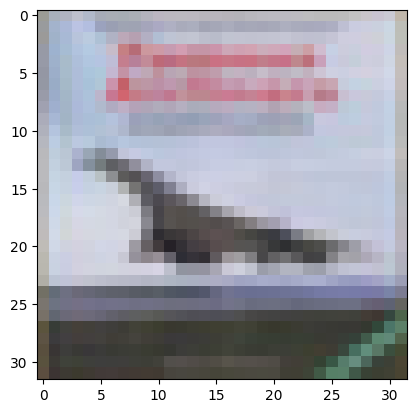

In [29]:
import matplotlib.pyplot as plt
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))